In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import gensim.downloader as api
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from gensim.models import Word2Vec
import time
import re

In [2]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 5.3 MB/s  0:00:14m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 5.3 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 5.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [torch]32m3/4 [torch]kx]


In [8]:
df_test = pd.read_csv('Corona_NLP_test.csv')

In [18]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [11]:
df_train = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [13]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [16]:
df_train.Sentiment.value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [23]:
df_test.Sentiment.value_counts()

Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64

In [25]:
# Объединяем экстремальные категории с основными
def simplify_sentiment(sentiment):
    if sentiment in ['Extremely Positive', 'Positive']:
        return 'Positive'
    elif sentiment in ['Extremely Negative', 'Negative']:
        return 'Negative'
    else:
        return 'Neutral'

# Применяем преобразование
df_train['Sentiment_simple'] = df_train['Sentiment'].apply(simplify_sentiment)
df_test['Sentiment_simple'] = df_test['Sentiment'].apply(simplify_sentiment)

In [29]:
# Функция для очистки текста
def clean_text(text):
    if isinstance(text, str):
        # Удаляем упоминания пользователей (@username)
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)
        # Удаляем URL
        text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)
        # Удаляем хэштеги (но оставляем текст)
        text = re.sub(r'#', '', text)
        # Удаляем специальные символы и цифры
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Приводим к нижнему регистру
        text = text.lower()
        # Удаляем лишние пробелы
        text = ' '.join(text.split())
        return text
    else:
        return ''

# Применяем очистку
df_train['cleaned_tweet'] = df_train['OriginalTweet'].apply(clean_text)
df_test['cleaned_tweet'] = df_test['OriginalTweet'].apply(clean_text)

In [30]:
df_train['cleaned_tweet'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: cleaned_tweet, dtype: object

In [31]:
# Дополнительная обработка текста с использованием NLTK
# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    # Токенизация
    tokens = text.split()
    # Удаляем стоп-слова и применяем стемминг
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Применяем дополнительную обработку
df_train['processed_tweet'] = df_train['cleaned_tweet'].apply(preprocess_text)
df_test['processed_tweet'] = df_test['cleaned_tweet'].apply(preprocess_text)

In [32]:
df_train['processed_tweet'].head()

0                                                     
1    advic talk neighbour famili exchang phone numb...
2    coronaviru australia woolworth give elderli di...
3    food stock one empti pleas dont panic enough f...
4    readi supermarket covid outbreak paranoid food...
Name: processed_tweet, dtype: object

In [33]:
# Подготовка данных для моделирования
X_train = df_train['processed_tweet']
y_train = df_train['Sentiment_simple']
X_test = df_test['processed_tweet']
y_test = df_test['Sentiment_simple']

In [35]:
# Кодируем метки
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [36]:
# Создаем валидационную выборку (10% от тренировочной)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_encoded, test_size=0.1, random_state=42, stratify=y_train_encoded)

In [37]:
# Токенизация текста
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_split)

In [38]:
# Функция для создания различных эмбеддингов
def get_embeddings(embedding_type='random', embedding_dim=100):
    if embedding_type == 'random':
        return None, embedding_dim
    
    elif embedding_type == 'word2vec':
        # Обучаем собственный Word2Vec
        sentences = [text.split() for text in X_train_split]
        word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
        return word2vec_model, embedding_dim
    
    elif embedding_type == 'glove':
        # Загружаем предобученные GloVe эмбеддинги
        try:
            glove_vectors = api.load('glove-twitter-100')
            return glove_vectors, 100
        except:
            print("GloVe не доступен, используем случайные эмбеддинги")
            return None, embedding_dim
    
    elif embedding_type == 'fasttext':
        # Загружаем FastText
        try:
            fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')
            return fasttext_vectors, 300
        except:
            print("FastText не доступен, используем случайные эмбеддинги")
            return None, embedding_dim
    
    return None, embedding_dim

In [39]:
# Функция для создания матрицы эмбеддингов
def create_embedding_matrix(embedding_model, word_index, embedding_dim):
    if embedding_model is None:
        return None
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    
    for word, i in word_index.items():
        if i < len(embedding_matrix):
            try:
                if hasattr(embedding_model, 'wv'):  # Для Word2Vec
                    if word in embedding_model.wv:
                        embedding_matrix[i] = embedding_model.wv[word]
                else:  # Для Gensim загруженных моделей
                    if word in embedding_model:
                        embedding_matrix[i] = embedding_model[word]
            except:
                continue
    
    return embedding_matrix

In [40]:
# Функция для создания различных архитектур нейросетей
def create_model(architecture='lstm', embedding_type='random', sequence_length=50, 
                 embedding_dim=100, hidden_units=64, dropout_rate=0.5, 
                 learning_rate=0.001, optimizer='adam', bidirectional=False,
                 regularization=0.01):
    
    # Получаем эмбеддинги
    embedding_model, actual_embedding_dim = get_embeddings(embedding_type, embedding_dim)
    embedding_dim = actual_embedding_dim
    
    # Создаем последовательности
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_split), 
                               maxlen=sequence_length, padding='post')
    X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), 
                             maxlen=sequence_length, padding='post')
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), 
                              maxlen=sequence_length, padding='post')
    
    # Создаем модель
    model = Sequential()
    
    # Слой эмбеддингов
    if embedding_model is not None:
        embedding_matrix = create_embedding_matrix(embedding_model, tokenizer.word_index, embedding_dim)
        if embedding_matrix is not None:
            model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=sequence_length,
                              trainable=False))
        else:
            model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                              output_dim=embedding_dim,
                              input_length=sequence_length))
    else:
        model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                          output_dim=embedding_dim,
                          input_length=sequence_length))
    
    # Архитектура сети
    if architecture == 'lstm':
        if bidirectional:
            model.add(Bidirectional(LSTM(hidden_units, return_sequences=False, 
                                       kernel_regularizer=l2(regularization))))
        else:
            model.add(LSTM(hidden_units, return_sequences=False, 
                         kernel_regularizer=l2(regularization)))
    
    elif architecture == 'gru':
        if bidirectional:
            model.add(Bidirectional(GRU(hidden_units, return_sequences=False,
                                      kernel_regularizer=l2(regularization))))
        else:
            model.add(GRU(hidden_units, return_sequences=False,
                        kernel_regularizer=l2(regularization)))
    
    elif architecture == 'cnn':
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(5))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
    
    elif architecture == 'hybrid':
        model.add(Conv1D(64, 3, activation='relu'))
        model.add(MaxPooling1D(2))
        if bidirectional:
            model.add(Bidirectional(LSTM(hidden_units, kernel_regularizer=l2(regularization))))
        else:
            model.add(LSTM(hidden_units, kernel_regularizer=l2(regularization)))
    
    # Полносвязные слои
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(regularization)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    model.add(Dense(3, activation='softmax'))
    
    # Компиляция
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model, X_train_seq, X_val_seq, X_test_seq

In [41]:
# Функция для обучения и оценки модели
def train_and_evaluate_model(model_params, epochs=20):
    start_time = time.time()
    
    print(f"Обучение модели с параметрами:")
    for key, value in model_params.items():
        print(f"  {key}: {value}")
    
    # Создаем модель
    model, X_train_seq, X_val_seq, X_test_seq = create_model(**model_params)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Обучение
    history = model.fit(
        X_train_seq, y_train_split,
        batch_size=32,
        epochs=epochs,
        validation_data=(X_val_seq, y_val),
        callbacks=[early_stopping],
        verbose=1)
    
    # Оценка на валидации
    val_pred_proba = model.predict(X_val_seq)
    val_pred = np.argmax(val_pred_proba, axis=1)
    val_f1 = f1_score(y_val, val_pred, average='macro')
    
    # Оценка на тесте
    test_pred_proba = model.predict(X_test_seq)
    test_pred = np.argmax(test_pred_proba, axis=1)
    test_f1 = f1_score(y_test_encoded, test_pred, average='macro')
    
    training_time = time.time() - start_time
    
    results = {'model': model,
        'history': history,
        'val_f1': val_f1,
        'test_f1': test_f1,
        'training_time': training_time,
        'predictions': test_pred}
    
    print(f"Время обучения: {training_time:.2f} сек")
    print(f"Macro F1 на валидации: {val_f1:.4f}")
    print(f"Macro F1 на тесте: {test_f1:.4f}")
    
    return results

In [42]:
# Эксперименты с различными параметрами
experiments = []

# Базовые эксперименты с разными архитектурами
base_params = [
    {'architecture': 'lstm', 'embedding_type': 'random', 'sequence_length': 50, 
     'embedding_dim': 100, 'hidden_units': 64, 'dropout_rate': 0.5, 
     'learning_rate': 0.001, 'optimizer': 'adam', 'bidirectional': False,
     'regularization': 0.01},
    
    {'architecture': 'lstm', 'embedding_type': 'random', 'sequence_length': 50,
     'embedding_dim': 100, 'hidden_units': 64, 'dropout_rate': 0.5,
     'learning_rate': 0.001, 'optimizer': 'adam', 'bidirectional': True,
     'regularization': 0.01},
    
    {'architecture': 'gru', 'embedding_type': 'random', 'sequence_length': 50,
     'embedding_dim': 100, 'hidden_units': 64, 'dropout_rate': 0.5,
     'learning_rate': 0.001, 'optimizer': 'adam', 'bidirectional': True,
     'regularization': 0.01},
    
    {'architecture': 'cnn', 'embedding_type': 'random', 'sequence_length': 50,
     'embedding_dim': 100, 'hidden_units': 64, 'dropout_rate': 0.5,
     'learning_rate': 0.001, 'optimizer': 'adam', 'bidirectional': False,
     'regularization': 0.01},
    
    {'architecture': 'hybrid', 'embedding_type': 'random', 'sequence_length': 50,
     'embedding_dim': 100, 'hidden_units': 64, 'dropout_rate': 0.5,
     'learning_rate': 0.001, 'optimizer': 'adam', 'bidirectional': True,
     'regularization': 0.01},
]

print("Эксперименты с архитектурами.")
for params in base_params:
    results = train_and_evaluate_model(params, epochs=30)
    experiments.append((params, results))

Эксперименты с архитектурами.
Обучение модели с параметрами:
  architecture: lstm
  embedding_type: random
  sequence_length: 50
  embedding_dim: 100
  hidden_units: 64
  dropout_rate: 0.5
  learning_rate: 0.001
  optimizer: adam
  bidirectional: False
  regularization: 0.01
Epoch 1/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.4331 - loss: 1.1357 - val_accuracy: 0.4385 - val_loss: 1.0442
Epoch 2/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.4379 - loss: 1.0443 - val_accuracy: 0.4385 - val_loss: 1.0432
Epoch 3/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.4385 - loss: 1.0439 - val_accuracy: 0.4385 - val_loss: 1.0434
Epoch 4/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.4384 - loss: 1.0434 - val_accuracy: 0.4385 - val_loss: 1.0432
Epoch 5/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.4385 - loss: 1.0438 - val_accuracy: 0.4385 - val_loss: 1.0432
Epoch 6/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accura

In [43]:
# Эксперименты с различными эмбеддингами
embedding_experiments = [
    {'architecture': 'lstm', 'embedding_type': 'word2vec', 'sequence_length': 50,
     'embedding_dim': 100, 'hidden_units': 64, 'dropout_rate': 0.5,
     'learning_rate': 0.001, 'optimizer': 'adam', 'bidirectional': True,
     'regularization': 0.01},
    
    {'architecture': 'lstm', 'embedding_type': 'glove', 'sequence_length': 50,
     'embedding_dim': 100, 'hidden_units': 64, 'dropout_rate': 0.5,
     'learning_rate': 0.001, 'optimizer': 'adam', 'bidirectional': True,
     'regularization': 0.01},
]

print("\nЭксперименты с эмбеддингами.")
for params in embedding_experiments:
    try:
        results = train_and_evaluate_model(params, epochs=30)
        experiments.append((params, results))
    except Exception as e:
        print(f"Ошибка при обучении с параметрами {params}: {e}")


Эксперименты с эмбеддингами.
Обучение модели с параметрами:
  architecture: lstm
  embedding_type: word2vec
  sequence_length: 50
  embedding_dim: 100
  hidden_units: 64
  dropout_rate: 0.5
  learning_rate: 0.001
  optimizer: adam
  bidirectional: True
  regularization: 0.01
Epoch 1/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.5401 - loss: 1.1595 - val_accuracy: 0.5807 - val_loss: 0.9405
Epoch 2/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.5802 - loss: 0.9331 - val_accuracy: 0.5692 - val_loss: 0.9255
Epoch 3/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.5952 - loss: 0.9161 - val_accuracy: 0.6101 - val_loss: 0.8897
Epoch 4/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.6090 - loss: 0.8986 - val_accuracy: 0.6239 - val_loss: 0.8759
Epoch 5/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.6174 - loss: 0.8922 - val_accuracy: 0.6365 - val_loss: 0.8579
Epoch 6/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accur

In [44]:
# Эксперименты с длиной последовательности и learning rate
advanced_experiments = [
    {'architecture': 'lstm', 'embedding_type': 'random', 'sequence_length': 30,
     'embedding_dim': 100, 'hidden_units': 128, 'dropout_rate': 0.3,
     'learning_rate': 0.0005, 'optimizer': 'adam', 'bidirectional': True,
     'regularization': 0.001},
    
    {'architecture': 'lstm', 'embedding_type': 'random', 'sequence_length': 100,
     'embedding_dim': 100, 'hidden_units': 128, 'dropout_rate': 0.3,
     'learning_rate': 0.0005, 'optimizer': 'adam', 'bidirectional': True,
     'regularization': 0.001},
    
    {'architecture': 'lstm', 'embedding_type': 'random', 'sequence_length': 50,
     'embedding_dim': 100, 'hidden_units': 128, 'dropout_rate': 0.3,
     'learning_rate': 0.01, 'optimizer': 'sgd', 'bidirectional': True,
     'regularization': 0.001},
    
    {'architecture': 'lstm', 'embedding_type': 'random', 'sequence_length': 50,
     'embedding_dim': 100, 'hidden_units': 128, 'dropout_rate': 0.3,
     'learning_rate': 0.001, 'optimizer': 'rmsprop', 'bidirectional': True,
     'regularization': 0.001},
]

print("\nЗапуск экспериментов...")
for params in advanced_experiments:
    results = train_and_evaluate_model(params, epochs=30)
    experiments.append((params, results))


Запуск экспериментов...
Обучение модели с параметрами:
  architecture: lstm
  embedding_type: random
  sequence_length: 30
  embedding_dim: 100
  hidden_units: 128
  dropout_rate: 0.3
  learning_rate: 0.0005
  optimizer: adam
  bidirectional: True
  regularization: 0.001
Epoch 1/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.6736 - loss: 0.8039 - val_accuracy: 0.7996 - val_loss: 0.5642
Epoch 2/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - accuracy: 0.8392 - loss: 0.4913 - val_accuracy: 0.8251 - val_loss: 0.5088
Epoch 3/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - accuracy: 0.8731 - loss: 0.4112 - val_accuracy: 0.8117 - val_loss: 0.5331
Epoch 4/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.8864 - loss: 0.3726 - val_accuracy: 0.8120 - val_loss: 0.5340
Epoch 5/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.8957 - loss: 0.3452 - val_accuracy: 0.8141 - val_loss: 0.5459
Epoch 6/30
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 46s 40ms/step - accuracy:

In [48]:
# Анализ результатов экспериментов

experiment_results = []
for i, (params, results) in enumerate(experiments):
    experiment_results.append({
        'experiment_id': i+1,
        'architecture': params['architecture'],
        'embedding_type': params['embedding_type'],
        'sequence_length': params['sequence_length'],
        'bidirectional': params['bidirectional'],
        'hidden_units': params['hidden_units'],
        'learning_rate': params['learning_rate'],
        'optimizer': params['optimizer'],
        'val_f1': results['val_f1'],
        'test_f1': results['test_f1'],
        'training_time': results['training_time']
    })

In [47]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame(experiment_results)
results_df = results_df.sort_values('test_f1', ascending=False)

print("\nТоп-5 моделей по Macro F1 на тесте:")
print(results_df.head(5).to_string(index=False))


Топ-5 моделей по Macro F1 на тесте:
 experiment_id architecture embedding_type  sequence_length  bidirectional  hidden_units  learning_rate optimizer   val_f1  test_f1  training_time
             5       hybrid         random               50           True            64          0.001      adam 0.817944 0.802041     149.767662
            10         lstm         random               50           True           128          0.010       sgd 0.812780 0.798636    1862.698047
             4          cnn         random               50          False            64          0.001      adam 0.818420 0.792312      75.853500
             2         lstm         random               50           True            64          0.001      adam 0.806043 0.791784     310.713968
            11         lstm         random               50           True           128          0.001   rmsprop 0.806802 0.790322     855.764882


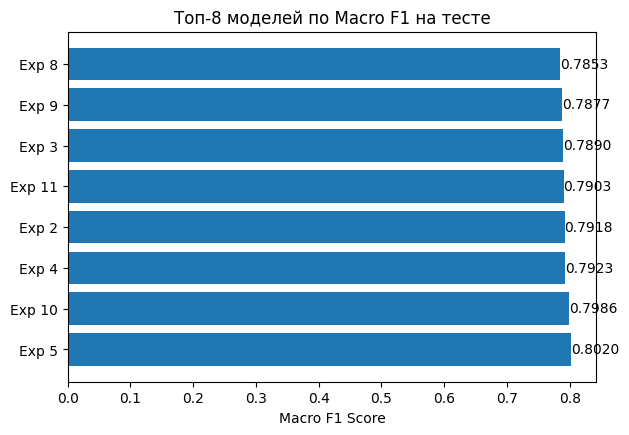

In [49]:
# Визуализация результатов
plt.figure(figsize=(15, 10))

# График 1: Сравнение F1 score
plt.subplot(2, 2, 1)
top_models = results_df.head(8)
plt.barh(range(len(top_models)), top_models['test_f1'])
plt.yticks(range(len(top_models)), [f"Exp {row.experiment_id}" for row in top_models.itertuples()])
plt.xlabel('Macro F1 Score')
plt.title('Топ-8 моделей по Macro F1 на тесте')
for i, v in enumerate(top_models['test_f1']):
    plt.text(v, i, f'{v:.4f}', va='center')

Text(0.5, 1.0, 'Соотношение времени обучения и качества')

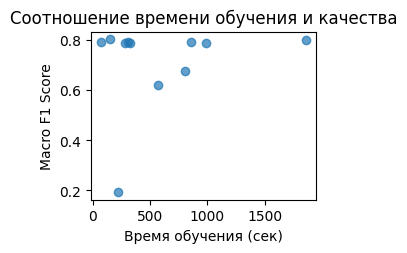

In [50]:
# График 2: Время обучения vs F1 score
plt.subplot(2, 2, 2)
plt.scatter(results_df['training_time'], results_df['test_f1'], alpha=0.7)
plt.xlabel('Время обучения (сек)')
plt.ylabel('Macro F1 Score')
plt.title('Соотношение времени обучения и качества')

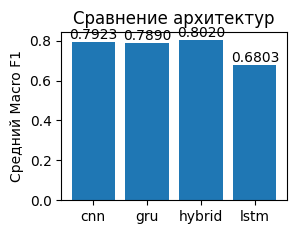

In [51]:
# График 3: Сравнение архитектур
plt.subplot(2, 2, 3)
arch_results = results_df.groupby('architecture')['test_f1'].mean()
plt.bar(arch_results.index, arch_results.values)
plt.ylabel('Средний Macro F1')
plt.title('Сравнение архитектур')
for i, v in enumerate(arch_results.values):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

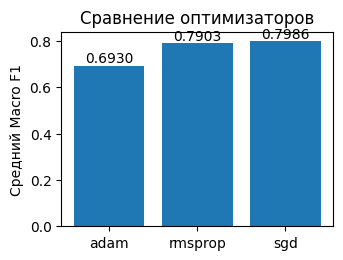

In [52]:
# График 4: Сравнение оптимизаторов
plt.subplot(2, 2, 4)
opt_results = results_df.groupby('optimizer')['test_f1'].mean()
plt.bar(opt_results.index, opt_results.values)
plt.ylabel('Средний Macro F1')
plt.title('Сравнение оптимизаторов')
for i, v in enumerate(opt_results.values):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [53]:
# Выбор и оценка лучшей модели
best_experiment_idx = results_df.iloc[0]['experiment_id'] - 1
best_params, best_results = experiments[best_experiment_idx]

print("ЛУЧШАЯ МОДЕЛЬ")
print(f"Параметры лучшей модели:")
for key, value in best_params.items():
    print(f"  {key}: {value}")
print(f"\nMacro F1 на тесте: {best_results['test_f1']:.4f}")
print(f"Время обучения: {best_results['training_time']:.2f} сек")

ЛУЧШАЯ МОДЕЛЬ
Параметры лучшей модели:
  architecture: hybrid
  embedding_type: random
  sequence_length: 50
  embedding_dim: 100
  hidden_units: 64
  dropout_rate: 0.5
  learning_rate: 0.001
  optimizer: adam
  bidirectional: True
  regularization: 0.01

Macro F1 на тесте: 0.8020
Время обучения: 149.77 сек


In [55]:
# Сохранение лучшей модели
best_model.save('best_sentiment_model.h5')
print("Лучшая модель сохранена как 'best_sentiment_model.h5'")

Лучшая модель сохранена как 'best_sentiment_model.h5'
